In [12]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras import models
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load Data

In [2]:
paths = []
labels = []
for _, folders, _ in os.walk(r'data'):
    for folder in folders:
        for dirname, _, filenames in os.walk(f'data\{folder}'):
            for filename in filenames:
                paths.append(os.path.join(dirname, filename))
                label = folder
                label = label.split('_')[0] # remove to segregate by gender
                labels.append(label.lower())

df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

print('Dataset is Loaded')
print(df.head())

Dataset is Loaded
                              speech  label
0   data\Angry_Female\anger_xn_1.wav  angry
1  data\Angry_Female\anger_xn_10.wav  angry
2  data\Angry_Female\anger_xn_11.wav  angry
3  data\Angry_Female\anger_xn_12.wav  angry
4  data\Angry_Female\anger_xn_13.wav  angry


# EDA

<Axes: xlabel='label'>

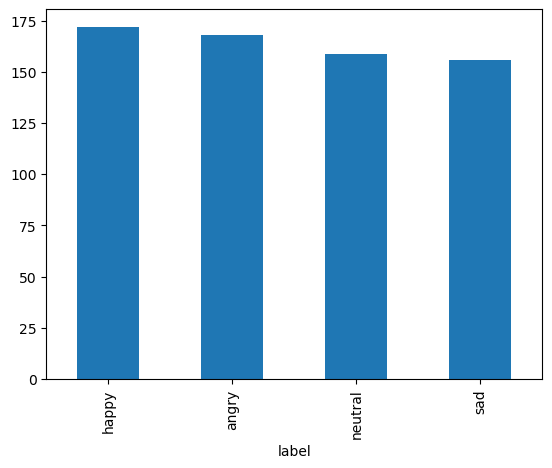

In [3]:
df['label'].value_counts().plot(kind='bar')

In [4]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr, color="blue")
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

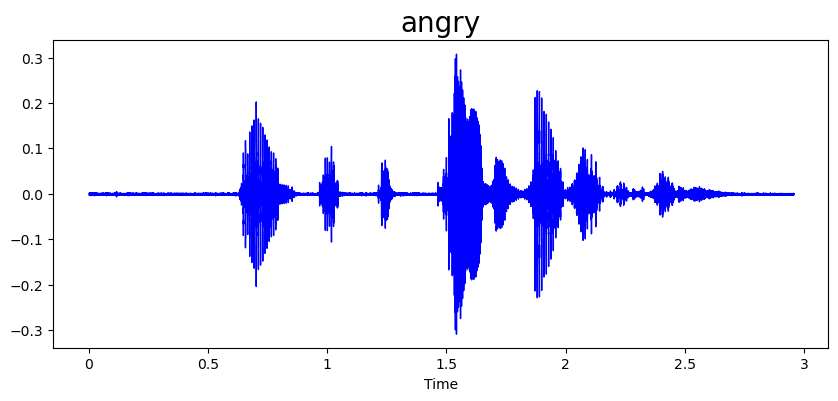

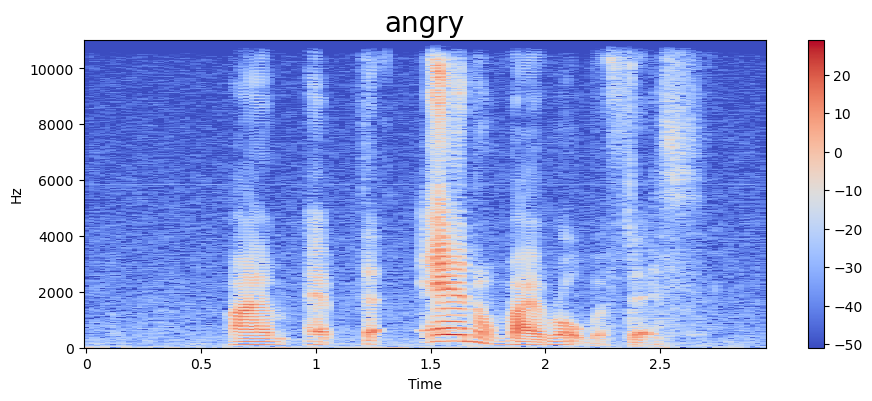

In [5]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[146]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

# Feature Engineering

In [6]:
# from sklearn.preprocessing import OneHotEncoder

# def extract_mfcc(filename):
#     y, sr = librosa.load(filename, duration=3, offset=0.5)
#     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
#     return mfcc

# def processData(df):
#     X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
#     print(X_mfcc.head())
#     X = [x for x in X_mfcc]
#     X = np.array(X)
#     X = np.expand_dims(X, -1)
#     print(X.shape)

#     enc = OneHotEncoder()
#     y = enc.fit_transform(df[['label']])
#     y = y.toarray()
#     print(y.shape)
#     return X, y, enc

In [7]:
# X, y, enc = processData(df)

In [8]:
from sklearn.preprocessing import OneHotEncoder

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    # print(mfcc)
    return mfcc

def extract_chroma(filename):
    y, sr = librosa.load(filename)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    return chroma

def extract_spectral_contrast(filename):
    y, sr = librosa.load(filename)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    return contrast

def extract_tonnetz(filename):
    y, sr = librosa.load(filename)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
    return tonnetz

def processData(df):
    # mfcc
    mfcc_columns = ['mfcc_' + str(i) for i in range(1, 41)]
    mfcc_df = pd.DataFrame(df['speech'].apply(lambda x: extract_mfcc(x)).tolist(), columns=mfcc_columns)
    new_df = pd.concat([df, mfcc_df], axis=1)

    # chroma 
    chroma_columns = ['chroma_' + str(i) for i in range(1, 13)]
    chroma_df = pd.DataFrame(df['speech'].apply(lambda x: extract_chroma(x)).tolist(), columns=chroma_columns)
    new_df = pd.concat([new_df, chroma_df], axis=1)

    # spectral_contrast
    spectral_columns = ['spectral_' + str(i) for i in range(1, 8)]
    spectral_df = pd.DataFrame(df['speech'].apply(lambda x: extract_spectral_contrast(x)).tolist(), columns=spectral_columns)
    new_df = pd.concat([new_df, spectral_df], axis=1)

    # tonnetz
    tonnetz_columns = ['tonnetz_' + str(i) for i in range(1, 8)]
    tonnetz_df = pd.DataFrame(df['speech'].apply(lambda x: extract_spectral_contrast(x)).tolist(), columns=tonnetz_columns)
    new_df = pd.concat([new_df, tonnetz_df], axis=1)

    return new_df

data = processData(df)

correlation_matrix = data[data.columns[2:]].corr()
pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if correlation_matrix.iloc[i, j] > 0.75 or correlation_matrix.iloc[i, j] < -0.75:
            pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

high_corr_df = pd.DataFrame(pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_set = set(high_corr_df['Feature 2'])

dropped_data = data.drop(columns=[col for col in data.columns if col in high_corr_set])
dropped_data.head()

,speech,label,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_9,...,mfcc_34,mfcc_36,mfcc_37,mfcc_38,mfcc_39,mfcc_40,chroma_1,chroma_8,spectral_1,spectral_2
0,data\Angry_Female\anger_xn_1.wav,angry,-494.275452,134.563019,-25.692623,44.874004,-6.713495,-20.871096,13.515035,-5.726561,...,1.314803,-0.579906,1.490515,-0.378105,0.367700,2.949149,0.402734,0.503801,31.923484,17.956310
1,data\Angry_Female\anger_xn_10.wav,angry,-489.237396,95.241463,-6.124708,45.021778,-1.017477,-12.822159,15.770239,-8.326755,...,-4.694559,-1.933444,-1.629161,-1.426133,-0.346760,0.731341,0.409627,0.526004,29.469380,16.135760
2,data\Angry_Female\anger_xn_11.wav,angry,-520.552795,101.389839,-10.185469,41.562035,3.115261,-10.974776,11.411966,-1.241703,...,-2.491965,-2.160133,-1.386096,-2.235185,-1.890604,-2.381725,0.627573,0.540234,28.944638,13.118379
3,data\Angry_Female\anger_xn_12.wav,angry,-490.044342,127.468536,-25.104696,38.669407,-12.717002,-19.364574,20.204561,-6.294516,...,-2.952660,-3.929294,-4.234304,-3.584727,-1.760653,-0.776542,0.454550,0.499391,29.633752,15.092322
4,data\Angry_Female\anger_xn_13.wav,angry,-475.499969,120.513458,-31.929777,47.917557,-6.103209,-19.414783,9.694455,-2.136702,...,3.392644,-2.054071,-1.458658,0.357163,-0.206766,-0.764464,0.350280,0.550284,30.638892,15.346131


In [9]:
def processData(df):
    X = df.drop(columns=["label", "speech"])
    X = np.expand_dims(X, -1)
    print(X.shape)

    enc = OneHotEncoder()
    y = enc.fit_transform(df[['label']])
    y = y.toarray()
    print(y.shape)
    return X, y, enc
X, y, enc = processData(dropped_data)

(655, 37, 1)
(655, 4)


# Model Training

In [10]:
from sklearn.model_selection import train_test_split

# Separate the test data
x_1, x_test, y_1, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)

# Split the remaining data to train and validation
x_train, x_val, y_train, y_val = train_test_split(x_1, y_1, test_size=0.15, shuffle=True)

In [24]:
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

model = models.Sequential()
model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(128, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(64, kernel_size=3, strides=1,
                        padding="same", activation="relu"))
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc", f1_m])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 37, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 19, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 10, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273,348 (1.04 MB)

 Trainable params: 273,348 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

# Model Evaluation

In [25]:
# Training the Keras model
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.2096 - f1_m: 0.2096 - loss: 21.7633 - val_acc: 0.2584 - val_f1_m: 0.2406 - val_loss: 10.8098
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.2528 - f1_m: 0.2527 - loss: 6.5107 - val_acc: 0.2135 - val_f1_m: 0.2242 - val_loss: 2.6864
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.2711 - f1_m: 0.1663 - loss: 1.9793 - val_acc: 0.2584 - val_f1_m: 0.2277 - val_loss: 1.5507
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.2378 - f1_m: 0.1844 - loss: 2.0406 - val_acc: 0.2472 - val_f1_m: 0.0000e+00 - val_loss: 1.6316
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.3024 - f1_m: 0.0434 - loss: 1.5252 - val_acc: 0.2584 - val_f1_m: 0.0793 - val_loss: 1.8954
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.2880 - f1_m: 0.0853 - loss: 1.9366 - val_acc: 0.2472 - val_f1_m: 0.1989 - val_loss: 1.6085
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.2809 - f1_m: 0.2450 - loss: 1.6495 - val_a

In [26]:
model.evaluate(x=x_test, y=y_test)
predictions = model.predict(x_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8539 - f1_m: 0.8776 - loss: 0.4968 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


----- F1 -----
0.8425339366515837
----- AUC ROC -----
0.9601742542485467
----- AUC ROC Curve -----


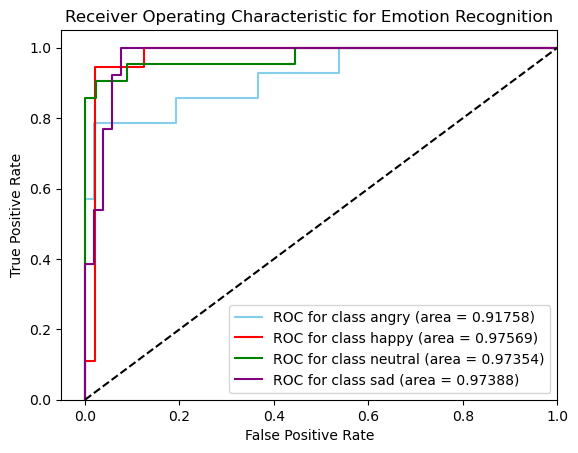

----- Confusion Matrix -----


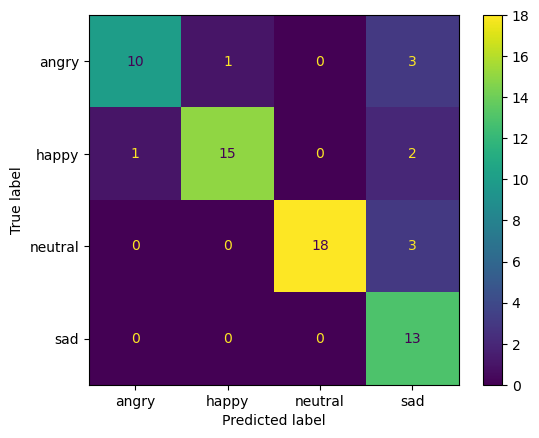

----- Classification Report -----
              precision    recall  f1-score   support

       angry       0.91      0.71      0.80        14
       happy       0.94      0.83      0.88        18
     neutral       1.00      0.86      0.92        21
         sad       0.62      1.00      0.76        13

    accuracy                           0.85        66
   macro avg       0.87      0.85      0.84        66
weighted avg       0.89      0.85      0.85        66



In [27]:
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report, 
    roc_curve, 
    auc,
    roc_auc_score,
    f1_score
)

print("----- F1 -----")
print(f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average="macro"))

print("----- AUC ROC -----")
print(roc_auc_score(y_test, predictions, multi_class="ovr", labels=list(enc.categories_[0])))

print("----- AUC ROC Curve -----")
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['skyblue', 'red', 'green', 'purple']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'ROC for class {list(enc.categories_[0])[i]} (area = {roc_auc[i]:.5f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Emotion Recognition')
plt.legend(loc="lower right")
plt.show()


print("----- Confusion Matrix -----")
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(enc.categories_[0]))
disp.plot()
plt.show()

print("----- Classification Report -----")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names=list(enc.categories_[0])))


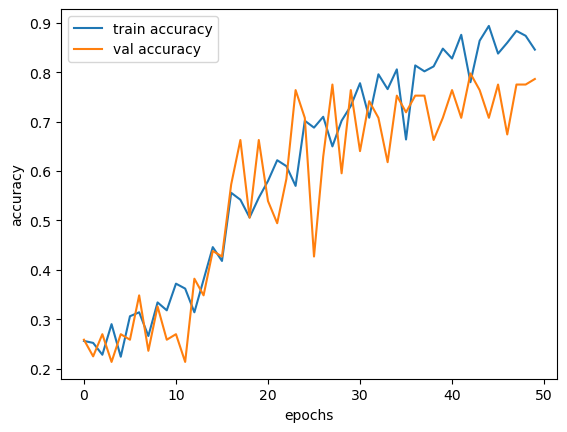

In [22]:
epochs = list(range(50))
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

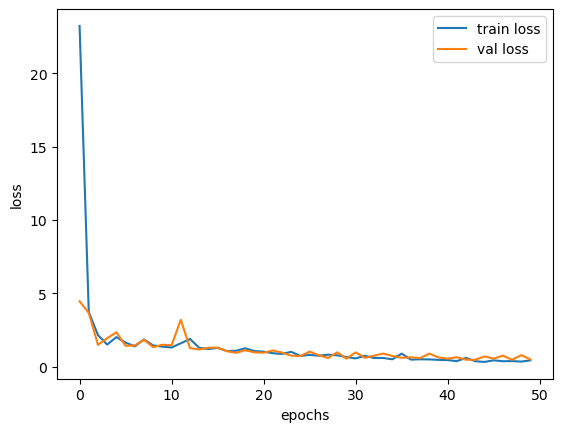

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()